# Introduction: Image Denoising with Convolutional Autoencoders

In agriculture, images captured by drones, satellites, or field cameras are invaluable for applications like crop monitoring, disease detection, yield prediction, and precision farming. However, these images often contain noise due to environmental factors such as poor lighting, motion blur, or sensor limitations. This noise can negatively impact the accuracy of downstream analytics and decision-making processes in agricultural systems.

Image denoising is a critical preprocessing step that enhances the quality of these images by removing unwanted noise while preserving essential features. Traditional methods, such as Gaussian or median filtering, often fail to generalize to the complex noise patterns found in agricultural imagery. To address these challenges, this project focuses on developing a robust Convolutional Autoencoder (CAE), a deep learning model designed to learn the mapping between noisy and clean images.



# Project Context

This notebook is part of a training exercise for my internship as a Machine Learning Engineer (MLE), where I am focusing on building robust machine learning models and scalable MLOps pipelines. 

The final objective of this training is to develop and deploy a production-ready denoising solution tailored for agricultural images, with a strong emphasis on:

- Automating machine learning pipelines (data preprocessing, training, evaluation, and deployment).
- Incorporating MLOps best practices (scalability, reproducibility, and monitoring).
- Delivering robust and reliable models for real-world agricultural applications.

# Key Objectives of This Notebook
- Train a Convolutional Autoencoder (CAE) to effectively denoise noisy agricultural images.
- Evaluate the model's performance using metrics like MSE 
- Visualize the results to analyze the effectiveness of the denoising process.
- Lay the foundation for integrating the model into an end-to-end MLOps pipeline, including deployment and scalability.

This training will allow me to gain hands-on experience in developing and optimizing machine learning solutions for real-world challenges while preparing for tasks required in my internship.

## Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import *
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from typing import Tuple, Optional

## Image Loading and Preprocessing

In [2]:
def read_data(path_list: list, im_size: tuple = (256, 256)) -> tuple:
    """
    Reads image data from a list of directory paths, resizes the images, and assigns labels based on directory structure.

    Parameters:
    - path_list (list of str): List of directory paths containing images organized in subfolders by label.
    - im_size (tuple of int): Target size for resizing images (width, height). Default is (256, 256).

    Returns:
    - X (numpy.ndarray): Array of resized images.
    - y (numpy.ndarray): One-hot encoded labels corresponding to the images.
    - tag2idx (dict): Dictionary mapping label names to numeric indices.

    Steps:
    1. Extracts unique labels from directory names and creates a label-to-index mapping.
    2. Iterates through all images in the directories, reads, resizes, and converts them to arrays.
    3. Handles errors gracefully, skipping files that are not valid images.

    Example Usage:
        path_list = ["data/class1/", "data/class2/"]
        X, y, tag2idx = read_data(path_list, im_size=(128, 128))
    """
    X = []
    y = []

    # Extract the file-names of the datasets we read and create a label dictionary.
    tag2idx = {tag.split(os.path.sep)[-1]: i for i, tag in enumerate(path_list)}
    print(tag2idx)

    for path in path_list:
        for im_file in tqdm(glob(path + "*/*")):  # Read all files in path
            try:
                # Extract the label from the folder name
                label = im_file.split(os.path.sep)[-2]
                im = cv2.imread(im_file, cv2.IMREAD_COLOR)
                # Convert BGR format (default in OpenCV) to RGB
                im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
                # Resize to the specified dimensions
                im = cv2.resize(im, im_size, interpolation=cv2.INTER_AREA)
                X.append(im)
                y.append(tag2idx[label])  # Append the label index
            except Exception as e:
                # Handle non-image files gracefully
                print(f"Skipping file {im_file}: {e}")

    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.eye(len(np.unique(y)))[y].astype(np.uint8)  # One-hot encode labels

    return X, y, tag2idx


In [4]:
def plot_sample(
    X: np.ndarray,
    nb_rows: int = 3,
    nb_cols: int = 3,
    figsize: Tuple[int, int] = (8, 8),
    seed: Optional[int] = None
) -> None:
    """
    Plots a grid of randomly selected sample images from a dataset.

    Parameters:
        X (np.ndarray): A dataset containing images, with shape 
                        (n_samples, height, width, channels).
        nb_rows (int): Number of rows in the grid. Default is 3.
        nb_cols (int): Number of columns in the grid. Default is 3.
        figsize (Tuple[int, int]): Size of the figure (width, height). Default is (8, 8).
        seed (Optional[int]): Random seed for reproducibility. Default is None.

    Returns:
        None: This function does not return a value; it displays a plot.
    
    Raises:
        ValueError: If X has fewer than nb_rows * nb_cols images.
    """
    if seed is not None:
        random.seed(seed)
    
    if X.shape[0] < nb_rows * nb_cols:
        raise ValueError(
            f"Dataset has fewer images ({X.shape[0]}) than the grid size ({nb_rows * nb_cols})."
        )

    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=figsize)

    for i in range(nb_rows):
        for j in range(nb_cols):
            axs[i, j].axis("off")
            axs[i, j].imshow(X[random.randint(0, X.shape[0] - 1)])

    plt.tight_layout()
    plt.show()


In [5]:
# Dataset parameters
IM_SIZE = (256, 256)       # Image size
TEST_SPLIT = 0.2           # Test set ratio
RANDOM_STATE = 42          # Seed for reproducibility

In [6]:
path_list = [str(Path(r"D:\data\Grape___Black_rot"))]
X, y, tag2idx = read_data(path_list,IM_SIZE )

print(f"Data shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Label dictionary: {tag2idx}")

{'Grape___Black_rot': 0}


  0%|          | 0/384 [00:00<?, ?it/s]

100%|██████████| 384/384 [00:01<00:00, 340.93it/s]


Data shape: (384, 256, 256, 3)
Labels shape: (384, 1)
Label dictionary: {'Grape___Black_rot': 0}


## Image Preprocessing

In [7]:
def prepare_noisy_data(
    X: tf.Tensor,
    y: tf.Tensor,
    test_split: float = 0.2,
    noise_factor: float = 0.3,
    random_state: int = 42
) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor, tf.Tensor, tf.Tensor, tf.Tensor]:
    """
    Prepares training and testing data by splitting the dataset, normalizing image data,
    and adding Gaussian noise to create noisy versions of the input images.

    Parameters:
        X (tf.Tensor): Input image data as a NumPy array or TensorFlow tensor of shape (n_samples, height, width, channels).
        y (tf.Tensor): Corresponding labels for the image data.
        test_split (float): Fraction of data to be used for testing. Default is 0.2.
        noise_factor (float): Magnitude of Gaussian noise to be added to the data. Default is 0.3.
        random_state (int): Random seed for reproducibility during the dataset split. Default is 42.

    Returns:
        Tuple[tf.Tensor, tf.Tensor, tf.Tensor, tf.Tensor, tf.Tensor, tf.Tensor]:
            - x_train (tf.Tensor): Normalized training images.
            - x_test (tf.Tensor): Normalized testing images.
            - x_train_noisy (tf.Tensor): Noisy training images.
            - x_test_noisy (tf.Tensor): Noisy testing images.
            - y_train (tf.Tensor): Training labels.
            - y_test (tf.Tensor): Testing labels.

    Raises:
        ValueError: If `X` and `y` have mismatched lengths.
    """
    # Ensure input data has consistent lengths
    if len(X) != len(y):
        raise ValueError(f"Input data X and labels y must have the same length. Found {len(X)} and {len(y)}.")

    # Split the dataset into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(
        X, y, test_size=test_split, shuffle=True, stratify=y, random_state=random_state
    )

    # Normalize the image data to the range [0, 1]
    x_train = x_train.astype("float32") / 255.0
    x_test = x_test.astype("float32") / 255.0

    # Add Gaussian noise to the images
    x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
    x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

    # Clip noisy images to ensure pixel values remain in the range [0, 1]
    x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0.0, clip_value_max=1.0)
    x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0.0, clip_value_max=1.0)

    return x_train, x_test, x_train_noisy, x_test_noisy, y_train, y_test


def plot_noisy_and_clean_images(
    clean_images: np.ndarray,
    noisy_images: np.ndarray,
    num_images: int = 10,
    figsize: tuple = (15, 6)
) -> None:
    """
    Plots clean images alongside their noisy counterparts in a grid with 2 rows and 5 columns.

    Parameters:
        clean_images (np.ndarray): Array of clean images, shape (n_samples, height, width, channels).
        noisy_images (np.ndarray): Array of noisy images, same shape as clean_images.
        num_images (int): Number of image pairs to display. Default is 10.
        figsize (tuple): Size of the figure (width, height). Default is (15, 6).

    Raises:
        ValueError: If clean_images and noisy_images have mismatched lengths.
    """
    if len(clean_images) != len(noisy_images):
        raise ValueError("Clean and noisy images must have the same number of samples.")

    num_images = min(num_images, len(clean_images))  # Limit to available samples

    # Create a figure with 2 rows and 5 columns
    fig, axes = plt.subplots(2, 5, figsize=figsize)

    for i in range(num_images):
        col = i % 5  # Determine the column index

        # Plot clean images in the first row
        axes[0, col].imshow(clean_images[i], cmap="gray")
        axes[0, col].axis("off")
        axes[0, col].set_title("Clean")

        # Plot noisy images in the second row
        axes[1, col].imshow(noisy_images[i], cmap="gray")
        axes[1, col].axis("off")
        axes[1, col].set_title("Noisy")

    plt.tight_layout()
    plt.show()



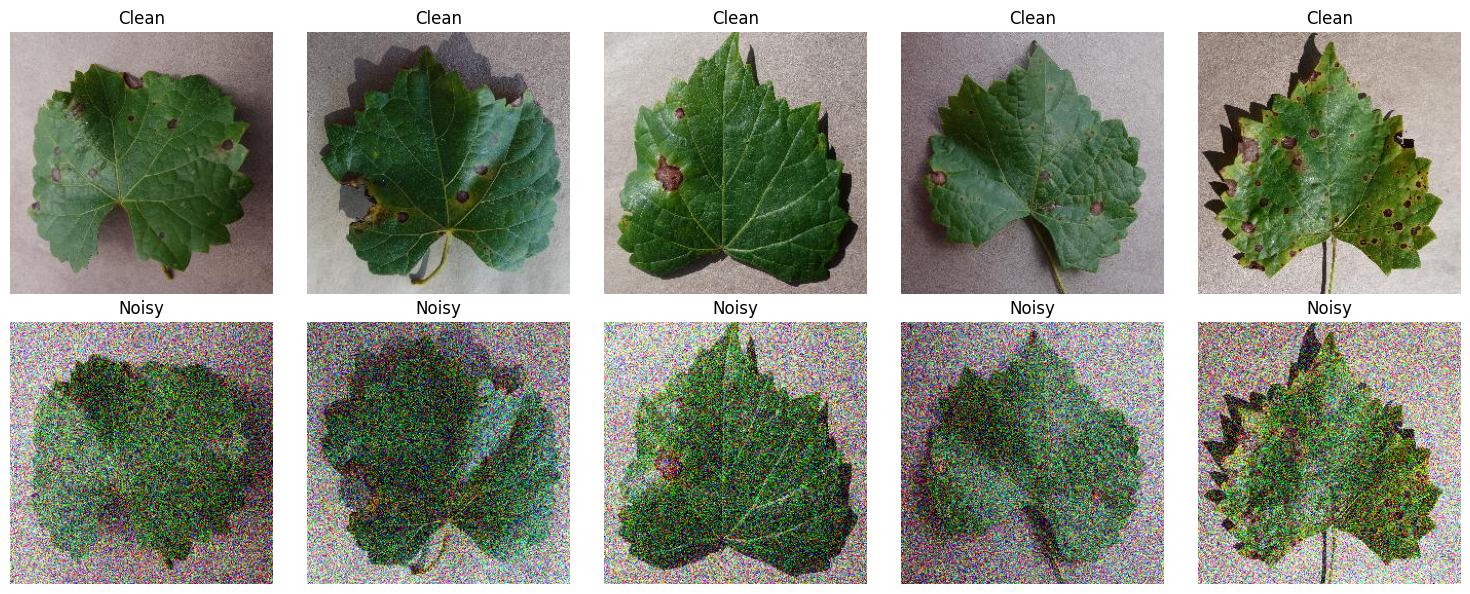

In [8]:
x_train, x_test, x_train_noisy, x_test_noisy, y_train, y_test = prepare_noisy_data(
    X, y, test_split=TEST_SPLIT, noise_factor=0.3, random_state=RANDOM_STATE
)
plot_noisy_and_clean_images(x_train, x_train_noisy, num_images=10, figsize=(15, 6))

First Row ("Clean"): The clean images of the leaves are displayed clearly, showcasing their natural state without any distortion or modifications.

Second Row ("Noisy"): The corresponding noisy images illustrate the effect of adding Gaussian noise, with visible pixel variations that simulate real-world noise. This can be useful for testing denoising algorithms or building robust image models.

Overall Grid: The layout effectively pairs each clean image with its noisy counterpart, making it easy to visually compare and assess the impact of noise on the ima

## Building and train a Flexible and Scalable Autoencoder Architecture

In [10]:
class FlexibleAutoencoder:
    def __init__(
        self,
        input_shape: Tuple[int, int, int],
        num_filters: Optional[list] = [64, 128, 256],  # Added 256 filters
        activation: str = "relu",
        learning_rate: float = 0.001,
    ):
        """
        Initialize a flexible autoencoder.

        Parameters:
            input_shape (Tuple[int, int, int]): Input shape of images (height, width, channels).
            num_filters (list): List of filter counts for Conv2D layers in the encoder/decoder.
            activation (str): Activation function to use in Conv2D layers. Default is 'relu'.
            learning_rate (float): Learning rate for the Adam optimizer. Default is 0.001.
        """
        self.input_shape = input_shape
        self.num_filters = num_filters
        self.activation = activation
        self.learning_rate = learning_rate
        self.autoencoder = None

    def build_encoder(self, input_layer):
        """
        Build the encoder part of the autoencoder.
        """
        x = input_layer
        for filters in self.num_filters:
            x = Conv2D(filters, (3, 3), activation=self.activation, padding="same")(x)
            x = MaxPooling2D((2, 2), padding="same")(x)
        return x

    def build_decoder(self, encoded):
        """
        Build the decoder part of the autoencoder.
        """
        x = encoded
        for filters in reversed(self.num_filters):
            x = Conv2D(filters, (3, 3), activation=self.activation, padding="same")(x)
            x = UpSampling2D((2, 2))(x)
        # Final layer to reconstruct the image
        decoded = Conv2D(self.input_shape[2], (3, 3), activation="sigmoid", padding="same")(x)
        return decoded

    def build_autoencoder(self):
        """
        Build the complete autoencoder model.
        """
        input_img = Input(shape=self.input_shape)
        encoded = self.build_encoder(input_img)
        decoded = self.build_decoder(encoded)
        self.autoencoder = Model(input_img, decoded)
        self.autoencoder.compile(optimizer=Adam(learning_rate=self.learning_rate), loss="mse")
        return self.autoencoder

    def summary(self):
        """
        Print the model summary.
        """
        if self.autoencoder is not None:
            self.autoencoder.summary()
        else:
            print("Autoencoder model is not built yet.")


In [11]:
# Training parameters
NUM_EPOCHS = 50            # Total training epochs
BATCH_SIZE = 8             # Batch size for training
BASE_LEARNING_RATE = 1e-3  # Initial learning rate
VERBOSE_LEVEL = 1   

In [12]:
input_shape = x_train.shape[1:]
autoencoder = FlexibleAutoencoder(
    input_shape=input_shape,
    num_filters=[64, 128, 256],  # Filters per layer
    activation="relu",
    learning_rate=BASE_LEARNING_RATE,
)
model = autoencoder.build_autoencoder()

In [13]:
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 256, 256, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,331,459 (5.08 MB)

 Trainable params: 1,331,459 (5.08 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    x_train_noisy, x_train,
    validation_data=(x_test_noisy, x_test),
    epochs=50,
    batch_size=BATCH_SIZE,
    verbose=VERBOSE_LEVEL
)

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 146s 4s/step - loss: 0.0350 - val_loss: 0.0089
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 145s 4s/step - loss: 0.0082 - val_loss: 0.0069
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - loss: 0.0068 - val_loss: 0.0066
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 164s 4s/step - loss: 0.0062 - val_loss: 0.0059
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 134s 3s/step - loss: 0.0056 - val_loss: 0.0055
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 232s 6s/step - loss: 0.0055 - val_loss: 0.0051
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 295s 8s/step - loss: 0.0054 - val_loss: 0.0048
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 125s 3s/step - loss: 0.0050 - val_loss: 0.0049
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - loss: 0.0048 - val_loss: 0.0046
Epoch 10/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 123s 3s/step - loss: 0.0048 - val_loss: 0.0045
Epoch 11/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 124s 3s/step - loss: 0.0045 - val_loss: 0.0044
Epoch 12/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 125s 3s/step - loss: 0.0

In [8]:
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.8, patience=50, verbose=VERBOSE_LEVEL)
early_stopping = EarlyStopping(monitor="val_loss", patience=100, restore_best_weights=True, verbose=VERBOSE_LEVEL)

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 921ms/step - loss: 0.0037
Test Loss: 0.0036273912992328405
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 942ms/step


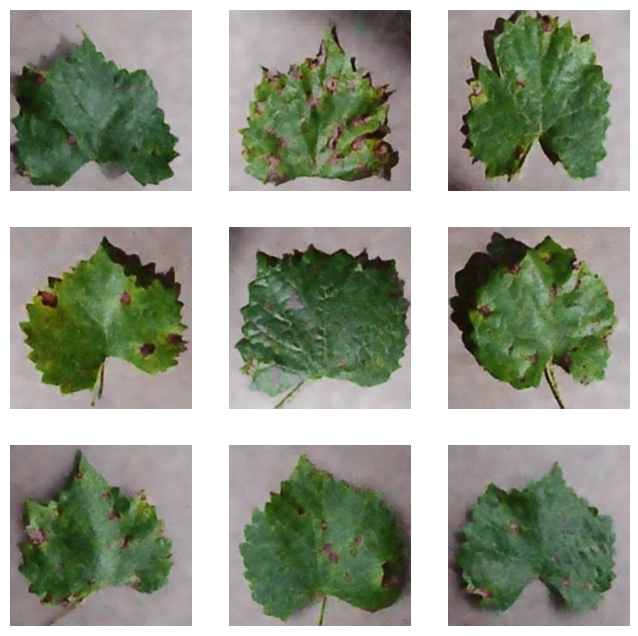

In [8]:
loss = autoencoder.evaluate(x_test_noisy, x_test)
print(f"Test Loss: {loss}")

# Predict and visualize
decoded_imgs = autoencoder.predict(x_test_noisy)
plot_sample(decoded_imgs)

In [24]:
decoded_imgs = autoencoder.predict(x_test_noisy)

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 890ms/step


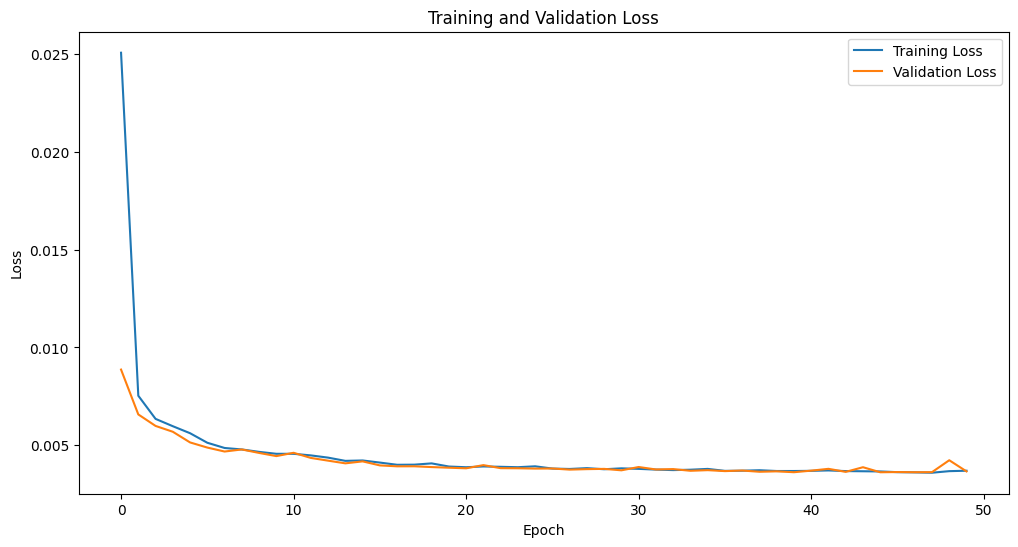

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

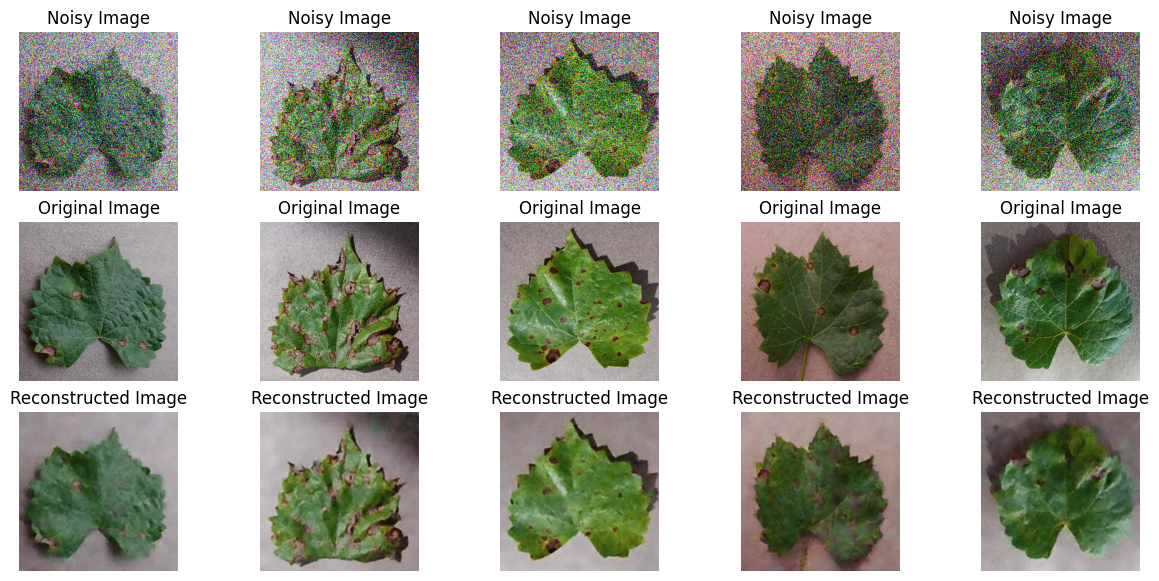

In [38]:
def plot_examples(original, noisy, reconstructed, num_examples=5):
    plt.figure(figsize=(15, 7))
    for i in range(num_examples):
        plt.subplot(3, num_examples, i + 1)
        plt.imshow(noisy[i])
        plt.title('Noisy Image')
        plt.axis('off')
        
        plt.subplot(3, num_examples, num_examples + i + 1)
        plt.imshow(original[i])
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(3, num_examples, 2 * num_examples + i + 1)
        plt.imshow(reconstructed[i])
        plt.title('Reconstructed Image')
        plt.axis('off')
    plt.show()

# Plot some example images
plot_examples(x_test, x_test_noisy, decoded_imgs)

In [27]:
autoencoder.save('autoencoder_model.keras')